In [122]:
# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
#from cartiflette.s3 import download_vectorfile_url_all
from scipy.stats import binom
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 40)

In [135]:
# Collecte des données
data=pd.read_csv("Donnees-sur-le-parc-de-vehicule-au-niveau-regional.2023-05.csv", sep=';',header=[1])
zones = gpd.read_file('aires.geojson')

In [117]:
# Variables utiles durant tout le programme
variables = ['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']
regions = data['REGION_LIBELLE'].unique()
regionsr = ['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Corse', 'Grand Est', 'Guadeloupe',
       'Guyane', 'Hauts-de-France', 'La Réunion',
       'Martinique', 'Mayotte', 'Normandie', 'Nouvelle-Aquitaine',
       'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur",
       'Île-de-France']
regionsmet = ['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Grand Est', 
        'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine',
       'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur",
       'Île-de-France']
regionsmethorsb = ['Auvergne-Rhône-Alpes', 'Bretagne',
       'Centre-Val de Loire', 'Grand Est', 
        'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine',
       'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur",
       'Île-de-France']
critair = data['CRITAIR'].unique()

In [118]:
critair

array(["Crit'Air 2", "Crit'Air 3", "Crit'Air 4", 'Non classé',
       "Crit'Air 5", "Crit'Air 1", "Crit'Air E", 'Inconnu'], dtype=object)

In [119]:
#Calcul de l'aire des zones de restriction de la circulation Crit'Air
aires = []
z = zones['geometry']
for i in range(len(z)):
    a = 0
    if z[i].type == 'Polygon':
        aires.append(poly.area)
    elif z[i].type == 'MultiPolygon':
        for poly in z[i].geoms:
            a += poly.area
        aires.append(a)
zones['Shape_Area']=aires

/tmp/ipykernel_265/2431039618.py:6: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if z[i].type == 'Polygon':
/tmp/ipykernel_265/2431039618.py:8: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif z[i].type == 'MultiPolygon':


# A - Statistiques descriptives

Merci pour toutes ces analyses Théo c'est grv propre ! Maintenant on peut se poser la question de "qu'est-ce qu'on garde comme Stats desc pour le code final ?". Je pense que tes graphes sur l'évolution du nombre de véhicule par carburant et par critère sont super, et il faut clairement les avoir. Sinon, je pense aussi (on peut en discuter) :

- Ajouter quelque chose du genre évolution du nombre de véhicules ayant été mis sur le marché la même année (je pourrai le faire ce we je pense), pour voir comment ils tombent en panne ou ils sont remplacés.
- Evolution des proportions de Crit'Air et de carburant pour les véhicules neufs.
- Evolution de l'âge moyen des voitures, peut être par carburant.

Aussi, tes graphes sur les taux de croissances sont nickel, il faut clairement les avoir.

D'ailleurs, je pense qu'on peut éliminer dès maintenant les véhicules autres que les véhicules particulier, avec : 

```python
data = data[data["CATEGORIE_VEHICULE"] == "Véhicule particulier"]
```

In [128]:
data

,REGION_CODE,REGION_LIBELLE,CLASSE_VEHICULE,CATEGORIE_VEHICULE,CARBURANT,AGE,STATUT_UTILISATEUR,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,84,Auvergne-Rhône-Alpes,tcp,Autobus,Diesel,0 an,Professionnel,Crit'Air 2,0,0,0,4,74,188,175,253,178,162,85,32
1,84,Auvergne-Rhône-Alpes,tcp,Autocar,Diesel,0 an,Professionnel,Crit'Air 2,0,0,0,9,436,644,644,693,556,709,383,331
2,84,Auvergne-Rhône-Alpes,tcp,Autobus,Diesel,0 an,Professionnel,Crit'Air 3,187,182,223,178,43,4,3,0,0,0,0,0
3,84,Auvergne-Rhône-Alpes,tcp,Autocar,Diesel,0 an,Professionnel,Crit'Air 3,487,552,500,713,194,20,2,2,0,0,0,0
4,84,Auvergne-Rhône-Alpes,tcp,Autobus,Diesel,0 an,Professionnel,Crit'Air 4,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59244,11,Île-de-France,pl,Camion,Gaz et inconnu,24 ans,Particulier,Non classé,0,0,0,0,0,0,0,0,0,0,0,0
59245,11,Île-de-France,pl,Camion,Gaz et inconnu,25 ans et plus,Professionnel,Non classé,1,1,1,1,0,0,0,0,0,0,0,0
59246,11,Île-de-France,pl,Tracteur routier,Gaz et inconnu,25 ans et plus,Professionnel,Non classé,0,0,0,0,0,0,0,0,0,0,0,0
59247,11,Île-de-France,pl,Camion,Gaz et inconnu,25 ans et plus,Particulier,Non classé,1,2,2,3,3,1,2,2,2,1,1,3


In [131]:
data = data[data["CATEGORIE_VEHICULE"] == "Véhicule particulier"].reset_index()

In [132]:
data

,index,REGION_CODE,REGION_LIBELLE,CLASSE_VEHICULE,CATEGORIE_VEHICULE,CARBURANT,AGE,STATUT_UTILISATEUR,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,33999,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 1,0,2,1,3,0,5,0,0,0,0,0,0
1,34000,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 2,22840,60245,58627,56823,55903,55948,59274,62531,56444,53142,37552,29362
2,34001,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 3,32626,2456,54,1,1,1,1,0,0,0,0,0
3,34002,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 4,7,1,0,0,1,0,0,0,0,0,0,0
4,34003,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 5,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14255,48254,11,Île-de-France,vp,Véhicule particulier,Gaz et inconnu,24 ans,Particulier,Crit'Air 3,0,0,0,0,0,0,0,0,0,0,0,1
14256,48255,11,Île-de-France,vp,Véhicule particulier,Gaz et inconnu,24 ans,Particulier,Non classé,379,35,24,38,71,51,41,29,32,40,37,0
14257,48256,11,Île-de-France,vp,Véhicule particulier,Gaz et inconnu,25 ans et plus,Professionnel,Non classé,16,14,15,10,13,9,9,12,12,9,11,14
14258,48257,11,Île-de-France,vp,Véhicule particulier,Gaz et inconnu,25 ans et plus,Particulier,Crit'Air 1,0,0,0,0,0,0,0,0,0,0,0,5


In [112]:
data["CRITAIR"].unique()

array(["Crit'Air 1", "Crit'Air 2", "Crit'Air 3", "Crit'Air 4",
       "Crit'Air 5", 'Non classé', "Crit'Air E", 'Inconnu'], dtype=object)

In [98]:
data.head()

,REGION_CODE,REGION_LIBELLE,CLASSE_VEHICULE,CATEGORIE_VEHICULE,CARBURANT,AGE,STATUT_UTILISATEUR,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
33999,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 1,0,2,1,3,0,5,0,0,0,0,0,0
34000,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 2,22840,60245,58627,56823,55903,55948,59274,62531,56444,53142,37552,29362
34001,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 3,32626,2456,54,1,1,1,1,0,0,0,0,0
34002,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 4,7,1,0,0,1,0,0,0,0,0,0,0
34003,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 5,0,1,0,0,0,0,0,0,0,0,0,0


In [99]:
data.describe()

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
count,14260.000000,14260.000000,14260.000000,14260.000000,14260.000000,14260.000000,14260.000000,14260.000000,14260.000000,14260.000000,14260.000000,14260.000000
mean,2475.424895,2492.303857,2509.666690,2535.009116,2569.977770,2607.300210,2641.898738,2674.391164,2682.077980,2695.365919,2698.492637,2716.577560
std,11967.944794,12221.374282,12426.326981,12601.754526,12795.459368,12944.406154,13056.584678,13137.046322,13165.472971,13246.539269,13181.531195,13048.860247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,57.000000,54.000000,56.000000,58.000000,61.000000,64.000000,64.000000,63.000000,67.000000,48.000000,58.000000,70.250000
max,186182.000000,189798.000000,193089.000000,197010.000000,198035.000000,197957.000000,194802.000000,190144.000000,189265.000000,186764.000000,183740.000000,194366.000000


In [100]:
# Visualisation du nombre de véhicule chaque année:
data.groupby('CATEGORIE_VEHICULE')[variables].sum()

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CATEGORIE_VEHICULE,,,,,,,,,,,,
Véhicule particulier,35299559,35540253,35787847,36149230,36647883,37180101,37673476,38136818,38246432,38435918,38480505,38738396


Nous pouvons voir que le nombre de véhicule par catégorie reste relativement identique au cours des années

In [101]:
# Visualisation du nombre de Crit'Air chaque année:
data.groupby('CRITAIR')[variables].sum()

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CRITAIR,,,,,,,,,,,,
Crit'Air 1,527854,1117200,1628418,2209327,2843000,3627493,4573613,5689663,7038271,8486922,9606394,10798122
Crit'Air 2,3789902,5316792,6759839,8048141,9248639,10321928,11295451,12142060,12842824,13548475,13972530,14155893
Crit'Air 3,13144926,12986403,12702081,12429698,12177620,11904009,11544080,11109790,10535664,9934637,9280651,8651975
Crit'Air 4,5846557,5728186,5612887,5476668,5331910,5141116,4897301,4591725,4166628,3669836,3231906,2862703
Crit'Air 5,2353321,2257293,2145067,2016426,1880410,1729316,1562731,1390437,1184214,959626,771784,653626
Crit'Air E,1279,3749,8791,16499,25329,41336,60910,82227,106440,141498,245281,403010
Inconnu,612,692,787,845,859,886,935,976,943,931,882,840
Non classé,9635108,8129938,6929977,5951626,5140116,4414017,3738455,3129940,2371448,1693993,1371077,1212227


En revanche la "qualité" (au niveau de la pollution) s'est très largement améliorée. Le nombre de "bons" crit'air a augmenté tandis que celui des "mauvais" a diminué.

In [102]:
# Regrouper les vignettes critair entre elles dans chaque régions pour ensuite pouvoir avoir le nombre de véhicules
# par critair, par régions
result2 = data.groupby(['REGION_LIBELLE','CRITAIR'])[variables].sum().reset_index()
result2.head()

,REGION_LIBELLE,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Auvergne-Rhône-Alpes,Crit'Air 1,62572,135079,201932,279593,362609,464754,586510,735710,910267,1094467,1246985,1403749
1,Auvergne-Rhône-Alpes,Crit'Air 2,462057,654032,841500,1011526,1166892,1303171,1428707,1540477,1635380,1727541,1782034,1805946
2,Auvergne-Rhône-Alpes,Crit'Air 3,1639482,1636182,1606966,1573164,1540317,1505355,1457811,1399206,1326404,1244632,1156096,1073771
3,Auvergne-Rhône-Alpes,Crit'Air 4,740712,726098,710307,688855,666985,639754,605562,564331,510770,446431,389436,344118
4,Auvergne-Rhône-Alpes,Crit'Air 5,287736,274382,258828,240004,221606,202168,181085,159483,135549,108933,86576,73775


In [103]:
result3 = data.groupby(['REGION_LIBELLE','CRITAIR','CARBURANT'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum().reset_index()
result3.head()

,REGION_LIBELLE,CRITAIR,CARBURANT,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Auvergne-Rhône-Alpes,Crit'Air 1,Diesel,1,2,3,7,6,8,6,5,2,1,1,1
1,Auvergne-Rhône-Alpes,Crit'Air 1,Diesel HNR,0,0,0,0,0,0,1,1,0,1,1,0
2,Auvergne-Rhône-Alpes,Crit'Air 1,Electrique et hydrogène,0,1,1,1,1,2,0,0,0,0,0,0
3,Auvergne-Rhône-Alpes,Crit'Air 1,Essence,39311,109824,175308,249662,329669,428139,544879,685020,847894,1020012,1143571,1244484
4,Auvergne-Rhône-Alpes,Crit'Air 1,Essence HNR,335,434,1868,5249,8534,11960,16805,24701,35197,45820,63754,95921


## Part Crit'air par région

À commenter

   index  PARC_2011  PARC_2012  PARC_2013  PARC_2014  PARC_2015  PARC_2016  \
0      0   35299559   35540253   35787847   36149230   36647883   37180101   
1      0   35299559   35540253   35787847   36149230   36647883   37180101   

   PARC_2017  PARC_2018  PARC_2019  PARC_2020  PARC_2021  PARC_2022  \
0   37673476   38136818   38246432   38435918   38480505   38738396   
1   37673476   38136818   38246432   38435918   38480505   38738396   

   DUMMY_CRITAIR  
0              0  
1              1  


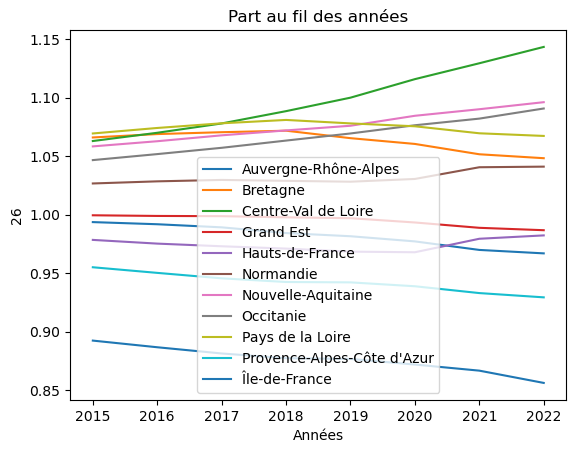

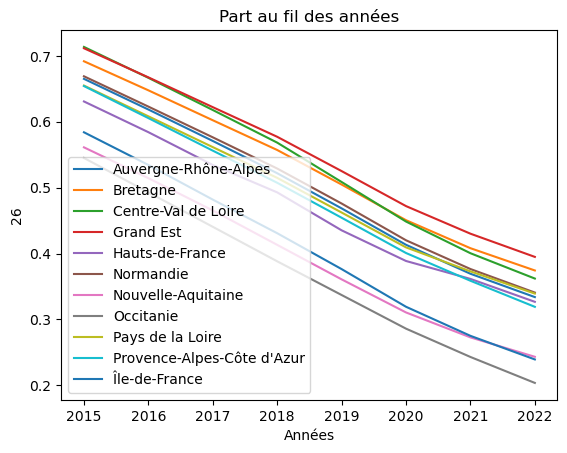

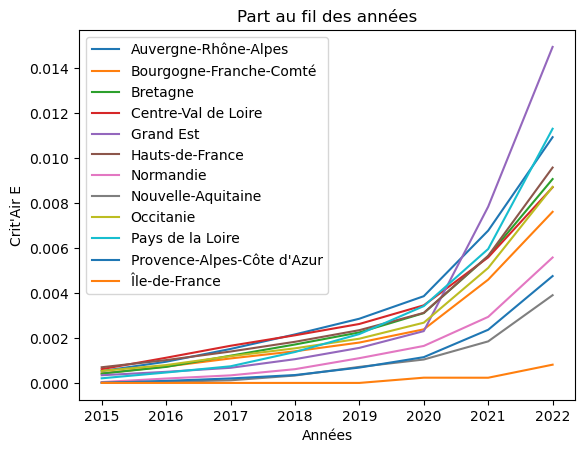

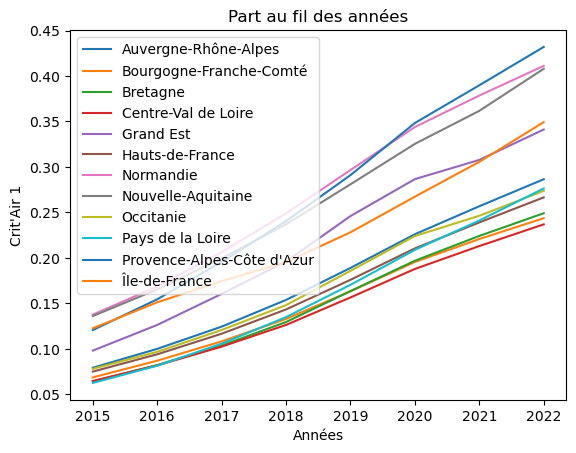

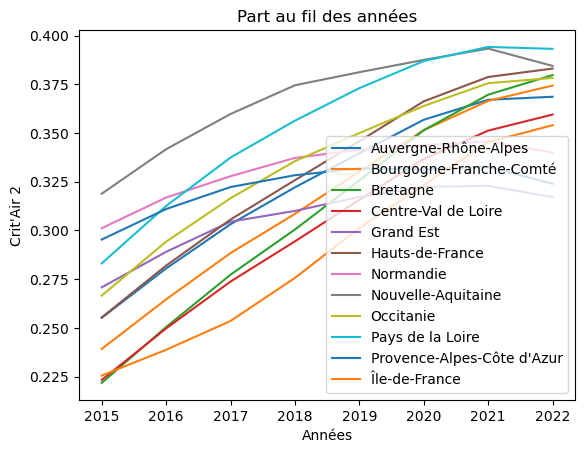

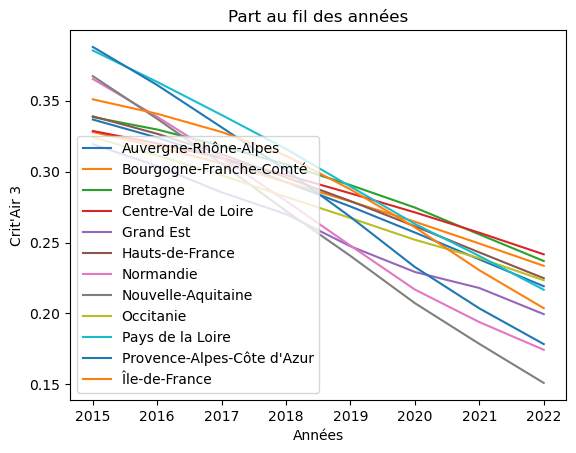

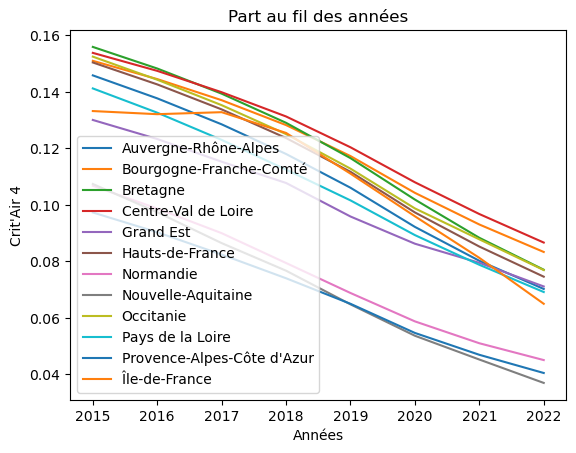

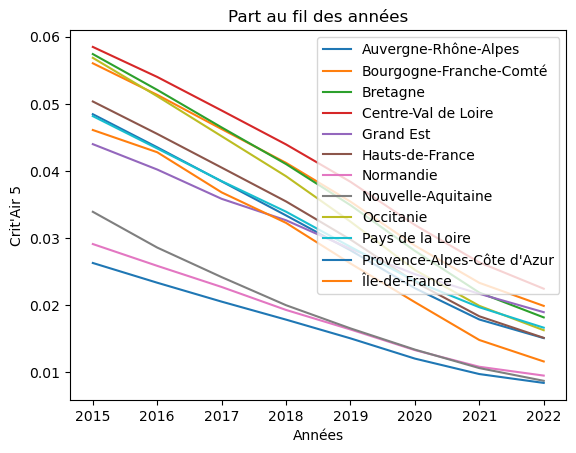

In [104]:
##Création d'une variable "dummy_critair" valant 0 pour les voiture les moins polluantes
data_dummy_critair = data.copy()
data_dummy_critair['DUMMY_CRITAIR'] = data_dummy_critair['CRITAIR'].apply(lambda x : 0 if (x in ["Crit'Air E","Crit'Air 1","Crit'Air 2"]) else 1)


sumregdum = data_dummy_critair.groupby(['REGION_LIBELLE','DUMMY_CRITAIR'])[variables].sum().reset_index()
sumregcrit = data_dummy_critair.groupby(['REGION_LIBELLE','CRITAIR'])[variables].sum().reset_index()
sumreg = data_dummy_critair.groupby(['REGION_LIBELLE'])[variables].sum().reset_index()
sumdum = data_dummy_critair.groupby(['DUMMY_CRITAIR'])[variables].sum().reset_index()
sumall = data_dummy_critair[variables].sum().to_frame().transpose()
result9 = pd.concat([sumall,sumall]).reset_index()
result9['DUMMY_CRITAIR']=[0,1]

print(result9)
ratiotot = sumdum.merge(result9, on=['DUMMY_CRITAIR'], suffixes = ('','_TOT'))
for k in range(11,23):
    ratiotot['PART_20'+str(k)] = ratiotot['PARC_20'+str(k)]/ratiotot['PARC_20'+str(k)+'_TOT']
ratiotot = ratiotot[ratiotot['DUMMY_CRITAIR']==1]
ratiotot = ratiotot[['PART_2011','PART_2012','PART_2013','PART_2014','PART_2015','PART_2016','PART_2017','PART_2018','PART_2019','PART_2020','PART_2021','PART_2022']]

ratiotot2 = pd.concat([ratiotot]*len(regionsmethorsb)).reset_index()
ratiotot2['REGION_LIBELLE'] = regionsmethorsb

sumreg = sumreg.sort_values(by=['REGION_LIBELLE'])
ratio = sumregdum.merge(sumreg, on=['REGION_LIBELLE'], suffixes = ('','_TOT'))
for k in range(11,23):
    ratio['PART_20'+str(k)] = ratio['PARC_20'+str(k)]/ratio['PARC_20'+str(k)+'_TOT']
ratio = ratio[ratio['DUMMY_CRITAIR']==1]
ratio = ratio[['REGION_LIBELLE','PART_2011','PART_2012','PART_2013','PART_2014','PART_2015','PART_2016','PART_2017','PART_2018','PART_2019','PART_2020','PART_2021','PART_2022']]
ratio = ratio.set_index('REGION_LIBELLE')

ratiofinal = ratio.merge(ratiotot2, on=['REGION_LIBELLE'], suffixes = ('','_TOT'))
for k in range(11,23):
    ratiofinal['PART_RELATIVE_20'+str(k)] = ratiofinal['PART_20'+str(k)]/ratiofinal['PART_20'+str(k)+'_TOT']
ratiofinal = ratiofinal[['PART_RELATIVE_2011','PART_RELATIVE_2012','PART_RELATIVE_2013','PART_RELATIVE_2014','PART_RELATIVE_2015','PART_RELATIVE_2016','PART_RELATIVE_2017','PART_RELATIVE_2018','PART_RELATIVE_2019','PART_RELATIVE_2020','PART_RELATIVE_2021','PART_RELATIVE_2022']]

#Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
Années=[2015,2016,2017,2018,2019,2020,2021,2022]
j=0
for c in regionsmethorsb:
    v=ratiofinal.iloc[j]
    v = v[4:]
    plt.plot(Années,v, label=c)
    j+=1

# Ajout des titres et légendes
plt.title('Part au fil des années')
plt.xlabel('Années')
plt.ylabel(i)
plt.legend()
plt.show()

#Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
Années=[2015,2016,2017,2018,2019,2020,2021,2022]
j=0
for c in regionsmethorsb:
    v=ratio.iloc[j]
    v = v[4:]
    plt.plot(Années,v, label=c)
    j+=1

# Ajout des titres et légendes
plt.title('Part au fil des années')
plt.xlabel('Années')
plt.ylabel(i)
plt.legend()
plt.show()

ratio = sumregcrit.merge(sumreg, on=['REGION_LIBELLE'], suffixes = ('','_TOT'))
for k in range(11,23):
    ratio['PART_20'+str(k)] = ratio['PARC_20'+str(k)]/ratio['PARC_20'+str(k)+'_TOT']

for i in ["Crit'Air E","Crit'Air 1","Crit'Air 2","Crit'Air 3","Crit'Air 4","Crit'Air 5"]:
    ratio2 = ratio[ratio['CRITAIR']==i]
    ratio2 = ratio2[['REGION_LIBELLE','PART_2011','PART_2012','PART_2013','PART_2014','PART_2015','PART_2016','PART_2017','PART_2018','PART_2019','PART_2020','PART_2021','PART_2022']]
    ratio2=ratio2.set_index('REGION_LIBELLE')
    
    #Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
    Années=[2015,2016,2017,2018,2019,2020,2021,2022]
    j=0
    for c in regionsmet:
        v=ratio2.iloc[j]
        v = v[4:]
        plt.plot(Années,v, label=c)
        j+=1
    
    # Ajout des titres et légendes
    plt.title('Part au fil des années')
    plt.xlabel('Années')
    plt.ylabel(i)
    plt.legend()
    plt.show()


Concernant les voitures électriques, leur part dans la population de voitures semble croitre exponentiellement.
Cela peut se justifier par le fait que plus de vootures sont produites, plus les coûts diminuent et plus la recherche pour de nouvelles technologies est rentable et donc intensive induisant une équation différentielle de la forme : f'(x) = a.f(x).
Leur part est aujourd'hui de l'ordre d'1%, néanmoins lorsqu'elle sera plus importante, le remplacement des voitures thermiques par des voitures électriques ralentira (voitures thermiques ayant une longue durée de vie, volonté de certaines personnes de ne pas changer de type de véhicule tant qu'ils le peuvent...).
Cela justifie une équation différentielle de la forme : f'(x) = a.f(x)(1-f(x)).
La solution d'une telle équation est de la forme f(x) = exp(ax)/(c+exp(ax)).
Les données disponibles nous permettent de trouver des valeurs probables de a et c avec une méthode de "fitting" : 

                  y   x
PARC_2011  0.000112   1
PARC_2012  0.000194   2
PARC_2013  0.000383   3
PARC_2014  0.000665   4
PARC_2015  0.000944   5
PARC_2016  0.001390   6
PARC_2017  0.001926   7
PARC_2018  0.002483   8
PARC_2019  0.003151   9
PARC_2020  0.004048  10
PARC_2021  0.006493  11
PARC_2022  0.010143  12
Paramètre a ajusté : 0.37052369183609457
Paramètre c ajusté : 8633.764171843413


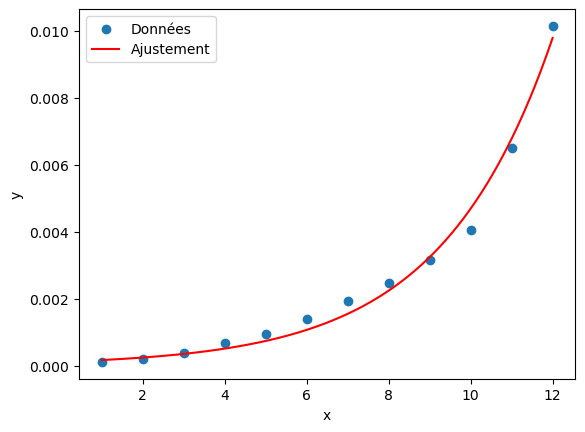

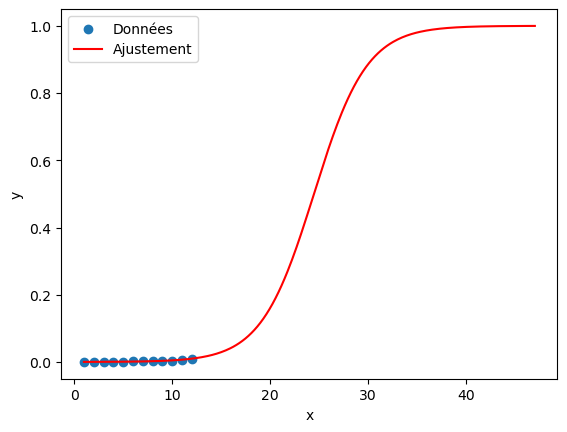

In [139]:
# Critair E 

données_pour_fit = data[data["CRITAIR"]=="Crit'Air E"][variables].sum().to_frame()
données_pour_fit.columns = ["Crit'Air E"]
tot = data[variables].sum().to_frame()
données_pour_fit['total']=tot
données_pour_fit['y'] = données_pour_fit["Crit'Air E"]/données_pour_fit['total']
données_pour_fit['x'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
données_pour_fit = données_pour_fit[['y','x']]
print(données_pour_fit)

# Fonction à ajuster
def func(x, a, c):
    return np.exp(a*x) / (c + np.exp(a*x))

# curve_fit pour ajuster les paramètres
# Des limites (bounds) sont ajoutées pour les paramètres afin d'éviter les problèmes de nombres trop grands
params, covariance = curve_fit(func, données_pour_fit['x'], données_pour_fit['y'], bounds=([0,0], [10,100000]))

# Valeurs ajustées
a_fit, c_fit = params

# Résultats
print(f"Paramètre a ajusté : {a_fit}")
print(f"Paramètre c ajusté : {c_fit}")

# Courbe ajustée
x_values = np.linspace(min(données_pour_fit['x']), max(données_pour_fit['x']), 300)
y_values_fit = func(x_values, a_fit, c_fit)

plt.scatter(données_pour_fit['x'], données_pour_fit['y'], label='Données')
plt.plot(x_values, y_values_fit, color='red', label='Ajustement')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

x_values = np.linspace(min(données_pour_fit['x']), max(données_pour_fit['x'])+35, 300)
y_values_fit = func(x_values, a_fit, c_fit)

plt.scatter(données_pour_fit['x'], données_pour_fit['y'], label='Données')
plt.plot(x_values, y_values_fit, color='red', label='Ajustement')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [107]:
data

,REGION_CODE,REGION_LIBELLE,CLASSE_VEHICULE,CATEGORIE_VEHICULE,CARBURANT,AGE,STATUT_UTILISATEUR,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
33999,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 1,0,2,1,3,0,5,0,0,0,0,0,0
34000,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 2,22840,60245,58627,56823,55903,55948,59274,62531,56444,53142,37552,29362
34001,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 3,32626,2456,54,1,1,1,1,0,0,0,0,0
34002,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 4,7,1,0,0,1,0,0,0,0,0,0,0
34003,84,Auvergne-Rhône-Alpes,vp,Véhicule particulier,Diesel,0 an,Professionnel,Crit'Air 5,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48254,11,Île-de-France,vp,Véhicule particulier,Gaz et inconnu,24 ans,Particulier,Crit'Air 3,0,0,0,0,0,0,0,0,0,0,0,1
48255,11,Île-de-France,vp,Véhicule particulier,Gaz et inconnu,24 ans,Particulier,Non classé,379,35,24,38,71,51,41,29,32,40,37,0
48256,11,Île-de-France,vp,Véhicule particulier,Gaz et inconnu,25 ans et plus,Professionnel,Non classé,16,14,15,10,13,9,9,12,12,9,11,14
48257,11,Île-de-France,vp,Véhicule particulier,Gaz et inconnu,25 ans et plus,Particulier,Crit'Air 1,0,0,0,0,0,0,0,0,0,0,0,5


In [108]:
ratiotot

,PART_2011,PART_2012,PART_2013,PART_2014,PART_2015,PART_2016,PART_2017,PART_2018,PART_2019,PART_2020,PART_2021,PART_2022
1,0.877646,0.818861,0.765366,0.71579,0.669368,0.623703,0.577157,0.530272,0.477401,0.423016,0.380876,0.345429


## Évolution du nombre de véhicules en fonction du carburant

In [93]:
result1 = data.groupby(['CARBURANT'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum().reset_index()

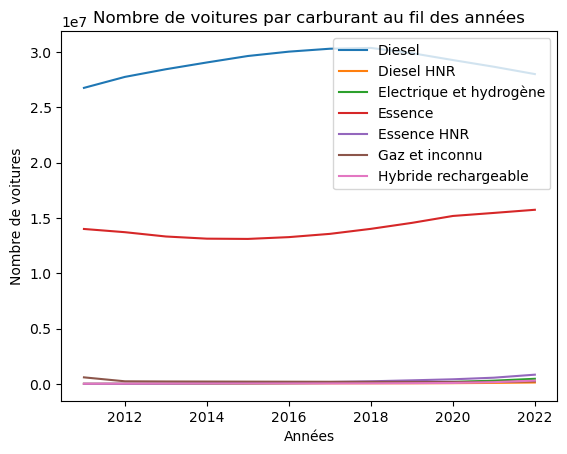

In [13]:
Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
i=0
v=result1.iloc[0]
v=v[1:]
for c in result1['CARBURANT']:
    v=result1.iloc[i]
    v=v[1:]
    plt.plot(Années,v, label=c)
    i+=1

# Ajout des titres et légendes
plt.title('Nombre de voitures par carburant au fil des années')
plt.xlabel('Années')
plt.ylabel('Nombre de voitures')
plt.legend()
plt.show()

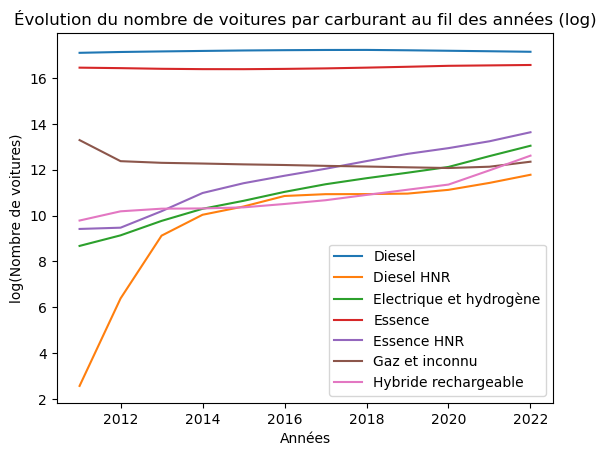

In [14]:
#Nous allons faire un passage au log pour enlever les effets d'échelles:
# Choisir les variables que l'on souhaite passer au logarithme
variables_a_logarithmer = ['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']

# Appliquez le logarithme à toutes les variables sélectionnées
result1[variables_a_logarithmer] = np.log(result1[variables_a_logarithmer])

v=result1.iloc[0]
v=v[1:]
Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
i=0
for c in result1['CARBURANT']:
    v=result1.iloc[i]
    v=v[1:]
    plt.plot(Années,v, label=c)
    i+=1

# Ajout des titres et légendes
plt.title('Évolution du nombre de voitures par carburant au fil des années (log)')
plt.xlabel('Années')
plt.ylabel('log(Nombre de voitures)')
plt.legend()
plt.show()

## Évolution du nombre de véhicules

In [15]:
def nb_vehicules(data):
    annees={'Années':[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]}
    annees=pd.DataFrame(annees)
    nb={'Nombre_Vehicules':[]}
    n=[]
    for k in range (11,23):
        n.append(data[f'PARC_20{k}'].sum())
    nb['Nombre_Vehicules']=n
    nb=pd.DataFrame(nb)
    df=pd.concat([annees,nb],axis=1)
    return df

In [16]:
df=nb_vehicules(data)
df

,Années,Nombre_Vehicules
0,2011,41411244
1,2012,41770040
2,2013,42090919
3,2014,42558879
4,2015,43167343
5,2016,43797518
6,2017,44428166
7,2018,45053898
8,2019,45247196
9,2020,45404223


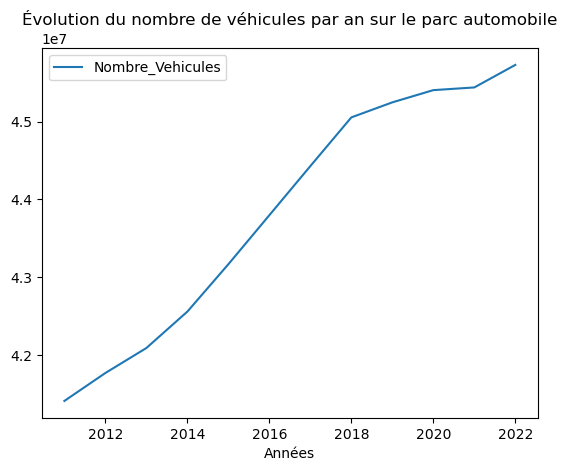

In [17]:
n=nb_vehicules(data).copy()
n=n.set_index('Années')
n.plot()
plt.title("Évolution du nombre de véhicules par an sur le parc automobile")
plt.show()

In [18]:
df['Taux de croissance'] = ((df['Nombre_Vehicules'] - df['Nombre_Vehicules'].shift(1)) / df['Nombre_Vehicules'].shift(1)) * 100
print(f"Le taux de croissance moyen (tout véhicules confondus) est de : {df['Taux de croissance'].mean()}")

Le taux de croissance moyen (tout véhicules confondus) est de : 0.906654946649314


In [19]:
df

,Années,Nombre_Vehicules,Taux de croissance
0,2011,41411244,NaN
1,2012,41770040,0.866422
2,2013,42090919,0.768204
3,2014,42558879,1.111784
4,2015,43167343,1.429699
5,2016,43797518,1.459842
6,2017,44428166,1.439917
7,2018,45053898,1.408413
8,2019,45247196,0.429037
9,2020,45404223,0.347042


## Évolution du nombre de voitures par crit'air

In [20]:
#Nous allons maintenant regarder la croissance de manière plus précise en regardant celle-ci pour chaque crit'air

In [21]:
result_crit = data.groupby(['CRITAIR'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum().reset_index()
result_crit

,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Crit'Air 1,546749,1138570,1652291,2237190,2874290,3664024,4617077,5744989,7113116,8587016,9725156,10946974
1,Crit'Air 2,3826368,5574126,7348515,8968353,10527295,11963735,13325544,14585321,15697826,16791261,17506252,17935698
2,Crit'Air 3,15058944,15043085,14744201,14442758,14130516,13797632,13384454,12894875,12249017,11539424,10786515,10053194
3,Crit'Air 4,7296685,7142718,6986207,6816882,6637426,6401865,6109626,5752477,5257681,4660227,4136723,3695476
4,Crit'Air 5,3115706,2986255,2836056,2674410,2507735,2322394,2122131,1915600,1665346,1379434,1140407,986711
5,Crit'Air E,4656,8097,16115,28302,40755,60884,85552,111862,142563,183817,295053,463817
6,Inconnu,1769,1891,2012,2099,2108,2241,2390,2532,2487,2418,2333,2161
7,Non classé,11560367,9875298,8505522,7388885,6447218,5584743,4781392,4046242,3119160,2260626,1846273,1644073


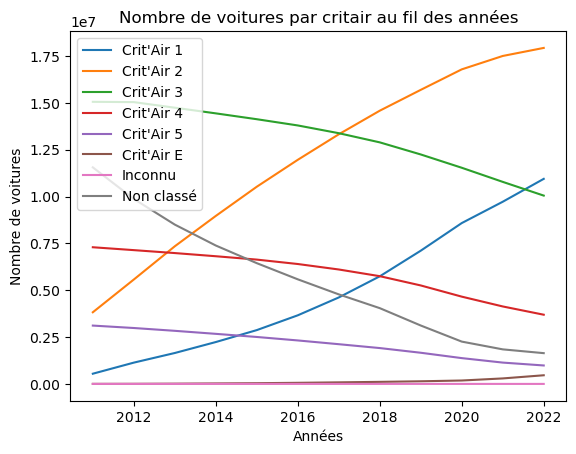

In [22]:
i=0
Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
v=result_crit.iloc[0]
v=v[1:]
for c in result_crit['CRITAIR']:
    v=result_crit.iloc[i]
    v=v[1:]
    plt.plot(Années,v, label=c)
    i+=1

# Ajout des titres et légendes
plt.title('Nombre de voitures par critair au fil des années')
plt.xlabel('Années')
plt.ylabel('Nombre de voitures')
plt.legend()
plt.show()

In [23]:
#Nous allons refaire la même chose que pour le carburant en passant au log.

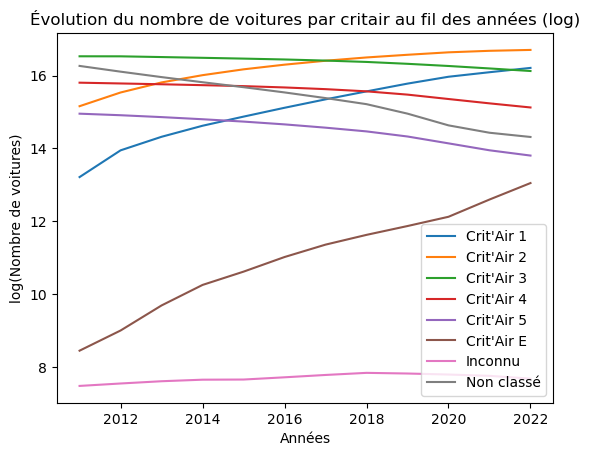

In [24]:
# Choisir les variables que l'on souhaite passer au logarithme
variables_a_logarithmer = ['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']

# Appliquez le logarithme à toutes les variables sélectionnées
result_crit[variables_a_logarithmer] = np.log(result_crit[variables_a_logarithmer])

v=result_crit.iloc[0]
v=v[1:]
Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
i=0
for c in result_crit['CRITAIR']:
    v=result_crit.iloc[i]
    v=v[1:]
    plt.plot(Années,v, label=c)
    i+=1

# Ajout des titres et légendes
plt.title('Évolution du nombre de voitures par critair au fil des années (log)')
plt.xlabel('Années')
plt.ylabel('log(Nombre de voitures)')
plt.legend()
plt.show()

## Taux de croissance en fonction des crit'air

In [25]:
#Nous allons maintenant nous intéresser au taux de croissance moyen pour chaque critair.
result = data.groupby(['CRITAIR'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum().reset_index()
result=result.set_index('CRITAIR')

In [26]:
df=result
df

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CRITAIR,,,,,,,,,,,,
Crit'Air 1,546749,1138570,1652291,2237190,2874290,3664024,4617077,5744989,7113116,8587016,9725156,10946974
Crit'Air 2,3826368,5574126,7348515,8968353,10527295,11963735,13325544,14585321,15697826,16791261,17506252,17935698
Crit'Air 3,15058944,15043085,14744201,14442758,14130516,13797632,13384454,12894875,12249017,11539424,10786515,10053194
Crit'Air 4,7296685,7142718,6986207,6816882,6637426,6401865,6109626,5752477,5257681,4660227,4136723,3695476
Crit'Air 5,3115706,2986255,2836056,2674410,2507735,2322394,2122131,1915600,1665346,1379434,1140407,986711
Crit'Air E,4656,8097,16115,28302,40755,60884,85552,111862,142563,183817,295053,463817
Inconnu,1769,1891,2012,2099,2108,2241,2390,2532,2487,2418,2333,2161
Non classé,11560367,9875298,8505522,7388885,6447218,5584743,4781392,4046242,3119160,2260626,1846273,1644073


In [27]:
# Calculer les taux de croissance pour chaque colonne
taux_de_croissance = df.pct_change(axis=1) * 100

# Calculer la moyenne des taux de croissance pour chaque ligne
taux_de_croissance_moyen = taux_de_croissance.mean(axis=1)

# Ajouter la colonne de taux de croissance moyen au DataFrame
df['Taux_croissance_moyen'] = taux_de_croissance_moyen

In [28]:
taux_de_croissance

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CRITAIR,,,,,,,,,,,,
Crit'Air 1,NaN,108.243636,45.119843,35.399273,28.477689,27.475794,26.011101,24.429136,23.814267,20.720877,13.254197,12.563480
Crit'Air 2,NaN,45.676683,31.832596,22.043066,17.382701,13.644911,11.382808,9.453850,7.627566,6.965519,4.258114,2.453101
Crit'Air 3,NaN,-0.105313,-1.986853,-2.044485,-2.161928,-2.355781,-2.994557,-3.657818,-5.008641,-5.793061,-6.524667,-6.798498
Crit'Air 4,NaN,-2.110095,-2.191197,-2.423704,-2.632523,-3.548981,-4.564904,-5.845677,-8.601442,-11.363451,-11.233444,-10.666583
Crit'Air 5,NaN,-4.154789,-5.029678,-5.699676,-6.232216,-7.390773,-8.623128,-9.732246,-13.064001,-17.168324,-17.327904,-13.477294
Crit'Air E,NaN,73.904639,99.024330,75.625194,44.000424,49.390259,40.516392,30.753226,27.445424,28.937382,60.514533,57.197859
Inconnu,NaN,6.896552,6.398731,4.324056,0.428776,6.309298,6.648817,5.941423,-1.777251,-2.774427,-3.515302,-7.372482
Non classé,NaN,-14.576259,-13.870731,-13.128377,-12.744372,-13.377475,-14.384744,-15.375230,-22.912174,-27.524526,-18.329127,-10.951793


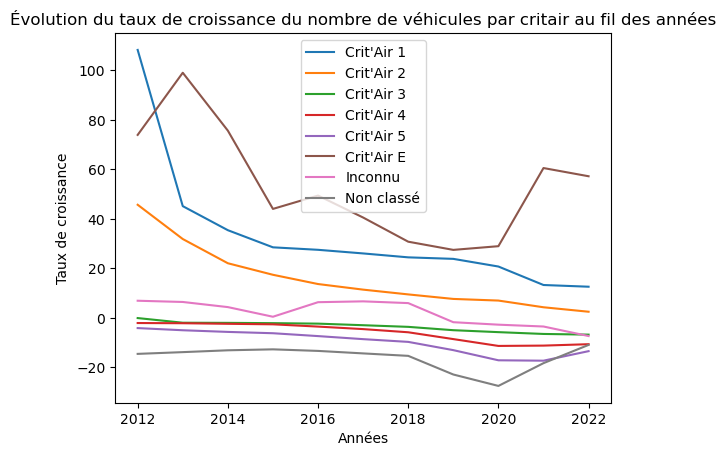

In [29]:
Années=[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
i=0
for c in taux_de_croissance.index:
    v=taux_de_croissance.iloc[i]
    v=v[1:]
    plt.plot(Années,v, label=c)
    i+=1
    
# Ajout des titres et légendes
plt.title('Évolution du taux de croissance du nombre de véhicules par critair au fil des années')
plt.xlabel('Années')
plt.ylabel('Taux de croissance')
plt.legend()
plt.show()

Il serait interessant de pouvoir prédire le taux de croissance jusqu'en 2035 ou 2050 !

In [30]:
#J'aimerais pouvoir comparer en fonction du type de véhicule, de la vignette critair et du carburant pour chaque région 
#afin de faire une carte interractive

In [31]:
#Quel est le carburant dominant dans chaque région?
count_df =data.groupby(["REGION_LIBELLE",'CARBURANT']).size().reset_index(name="Count")
count_df.head()

,REGION_LIBELLE,CARBURANT,Count
0,Auvergne-Rhône-Alpes,Diesel,1751
1,Auvergne-Rhône-Alpes,Diesel HNR,123
2,Auvergne-Rhône-Alpes,Electrique et hydrogène,286
3,Auvergne-Rhône-Alpes,Essence,749
4,Auvergne-Rhône-Alpes,Essence HNR,128


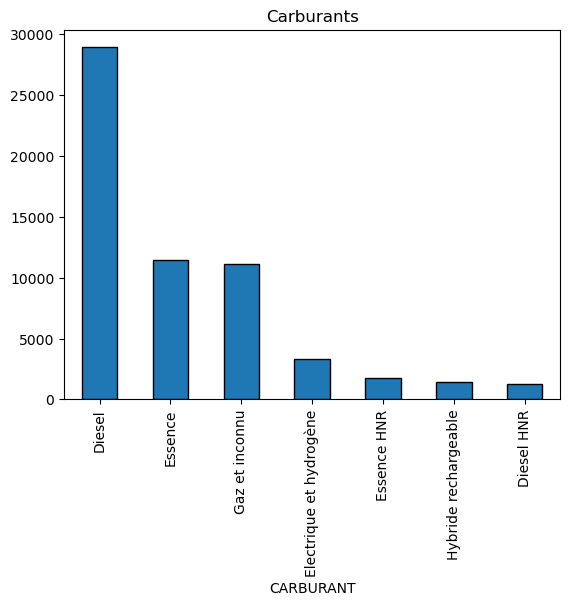

In [32]:
#Répartition des différents carburants dans notre échantillon
data['CARBURANT'].value_counts().plot(kind='bar', edgecolor='black')
plt.title("Carburants")
plt.show()

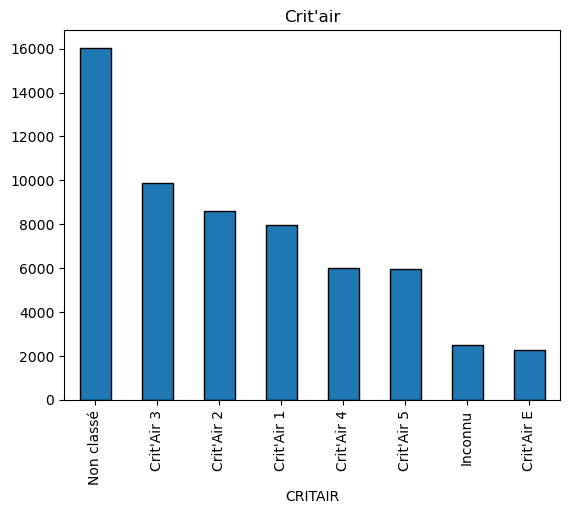

In [33]:
#Répartition des différentes vignettes critair dans notre échantillon:
data['CRITAIR'].value_counts().plot(kind='bar', edgecolor='black')
plt.title("Crit'air")
plt.show()

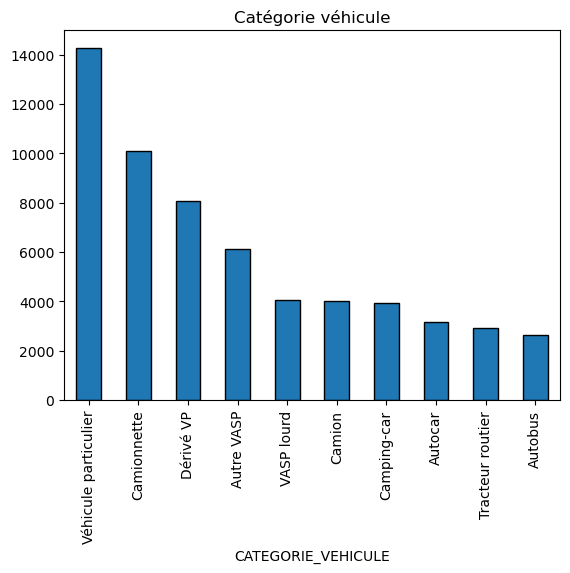

In [34]:
data['CATEGORIE_VEHICULE'].value_counts().plot(kind='bar', edgecolor='black')
plt.title("Catégorie véhicule")
plt.show()

## Île-de-France

In [35]:
iledefrance=data.loc[data['REGION_LIBELLE']=="Île-de-France"].copy()
iledefrance.head()

,REGION_CODE,REGION_LIBELLE,CLASSE_VEHICULE,CATEGORIE_VEHICULE,CARBURANT,AGE,STATUT_UTILISATEUR,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
5390,11,Île-de-France,tcp,Autobus,Diesel,0 an,Professionnel,Crit'Air 2,0,0,0,42,529,403,251,315,489,213,212,83
5391,11,Île-de-France,tcp,Autocar,Diesel,0 an,Professionnel,Crit'Air 2,0,0,0,10,823,1264,1253,1175,1160,1246,930,784
5392,11,Île-de-France,tcp,Autobus,Diesel,0 an,Professionnel,Crit'Air 3,539,632,553,568,88,9,0,0,0,0,0,0
5393,11,Île-de-France,tcp,Autocar,Diesel,0 an,Professionnel,Crit'Air 3,969,1264,1031,1054,310,26,9,1,0,0,0,0
5394,11,Île-de-France,tcp,Autocar,Diesel,0 an,Professionnel,Crit'Air 4,8,0,0,0,0,0,0,0,0,0,0,0


## Attribution des vignettes crit'air

In [36]:
def attribuer_vignette_critair(age,carburant):
    # Logique de votre attribution de vignette en fonction des caractéristiques du véhicule
    if carburant== "Electrique et hydrogène":
        return "Crit'Air E"
    elif carburant =="Hybride rechargeable" or carburant=="Gaz et inconnu":
        return "Crit'Air 1"
    elif carburant =="Essence" or carburant =="Essence HNR":
        if age > 26:
            return "Non classé"
        elif age <=26 and age >=18 :
            return "Crit'Air 3"
        elif age <=17 and age >=13 :
            return "Crit'Air 2"
        else :
            return "Crit'Air 1"
    
    elif carburant == "Diesel" or carburant =="Diesel HNR":
        if age > 26:
            return "Non classé"
        elif age <26 and age >=23 :
            return "Crit'Air 5"
        elif age <23 and age >=18 :
            return "Crit'Air 4"
        elif age <18 and age >=13 :
            return "Crit'Air 3"
        elif age <13:
            return "Crit'Air 2"

In [37]:
attribuer_vignette_critair(3,'Electrique et hydrogène')

"Crit'Air E"

## Modélisation de l'évolution du parc automobile

In [40]:
#D'après les études précédentes nous savons les taux de croissances suivant:

#taux_de_croissance['Mean']=taux_de_croissance.mean(axis=1)
taux_de_croissance=taux_de_croissance.drop('PARC_2011', axis=1).copy() #On retire les valeurs NA

In [41]:
taux_de_croissance

,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CRITAIR,,,,,,,,,,,
Crit'Air 1,108.243636,45.119843,35.399273,28.477689,27.475794,26.011101,24.429136,23.814267,20.720877,13.254197,12.563480
Crit'Air 2,45.676683,31.832596,22.043066,17.382701,13.644911,11.382808,9.453850,7.627566,6.965519,4.258114,2.453101
Crit'Air 3,-0.105313,-1.986853,-2.044485,-2.161928,-2.355781,-2.994557,-3.657818,-5.008641,-5.793061,-6.524667,-6.798498
Crit'Air 4,-2.110095,-2.191197,-2.423704,-2.632523,-3.548981,-4.564904,-5.845677,-8.601442,-11.363451,-11.233444,-10.666583
Crit'Air 5,-4.154789,-5.029678,-5.699676,-6.232216,-7.390773,-8.623128,-9.732246,-13.064001,-17.168324,-17.327904,-13.477294
Crit'Air E,73.904639,99.024330,75.625194,44.000424,49.390259,40.516392,30.753226,27.445424,28.937382,60.514533,57.197859
Inconnu,6.896552,6.398731,4.324056,0.428776,6.309298,6.648817,5.941423,-1.777251,-2.774427,-3.515302,-7.372482
Non classé,-14.576259,-13.870731,-13.128377,-12.744372,-13.377475,-14.384744,-15.375230,-22.912174,-27.524526,-18.329127,-10.951793


In [44]:
#On va tenter de prédire le taux de croissance pour chaque vignette crit'air à l'aide d'une régression linéaire:
annees = annees = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11])
annees = annees.reshape(-1, 1)
modele = LinearRegression()
annee_future = 12

def prediction(i):
    # Ajustez le modèle aux données d'entraînement
    modele.fit(annees, taux_de_croissance.iloc[i])
    
    # Prédisez le taux de croissance pour une année future
    taux_predit = modele.predict([[annee_future]])
    
    # Affichez les résultats
    print(f"Taux de croissance prédit pour l'année {annee_future}: {taux_predit[0]}")

    # Affichez les données d'origine et la ligne de régression
    plt.scatter(annees, taux_de_croissance.iloc[i], label='Données historiques')
    plt.plot(annees, modele.predict(annees), color='red', label='Régression linéaire')
    plt.scatter(annee_future, taux_predit, color='green', marker='x', label=f'Prédiction pour {annee_future}')
    plt.xlabel('Années')
    plt.ylabel('Taux de croissance')
    plt.legend()
    plt.show()

Taux de croissance prédit pour l'année 12: -2.895813101598293


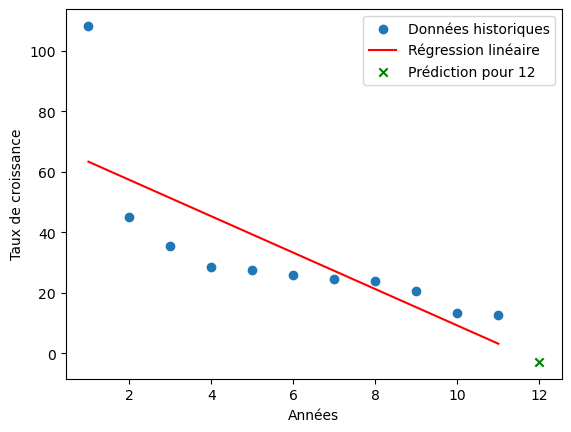

In [45]:
prediction(0)

Prédiction pour Crit'Air 1
Taux de croissance prédit pour l'année 12: -2.895813101598293


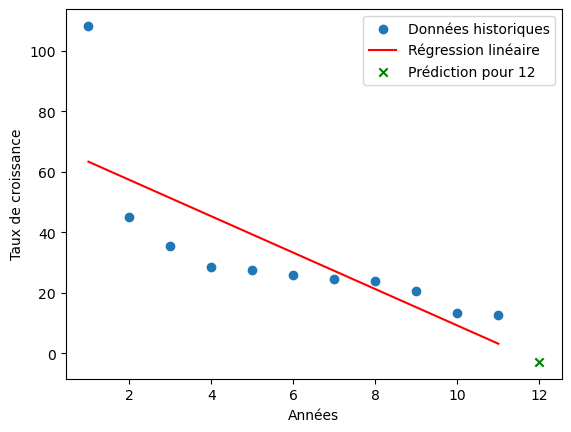

Prédiction pour Crit'Air 2
Taux de croissance prédit pour l'année 12: -5.862633937964702


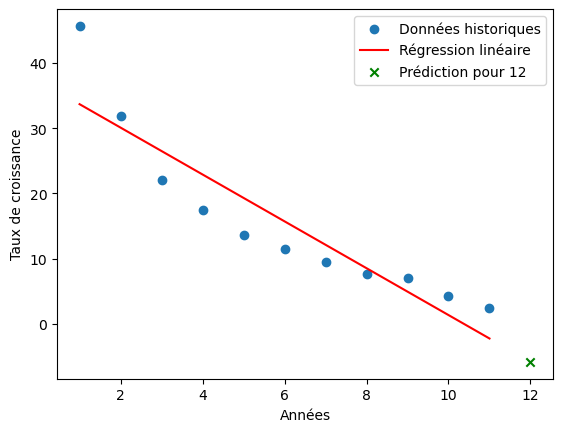

Prédiction pour Crit'Air 3
Taux de croissance prédit pour l'année 12: -7.395147775033973


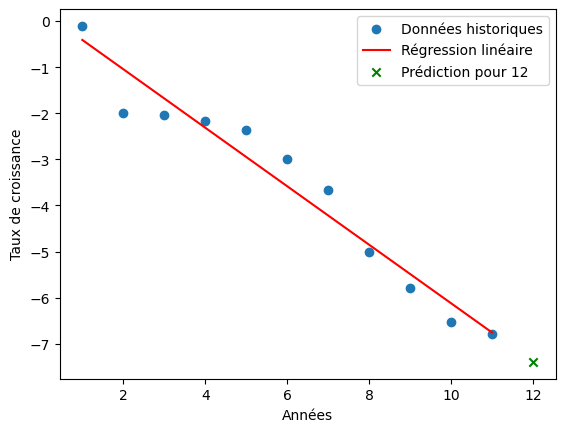

Prédiction pour Crit'Air 4
Taux de croissance prédit pour l'année 12: -12.471374998921284


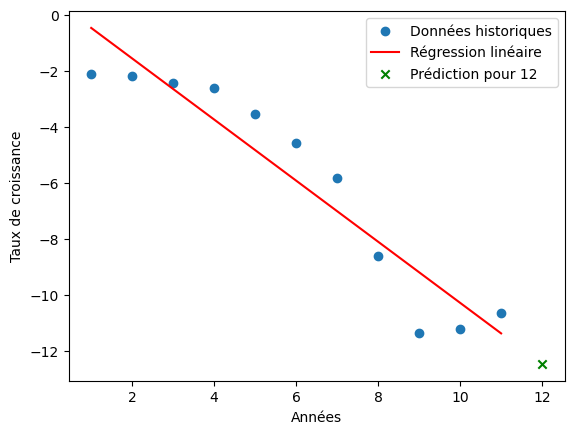

Prédiction pour Crit'Air 5
Taux de croissance prédit pour l'année 12: -17.78453433820695


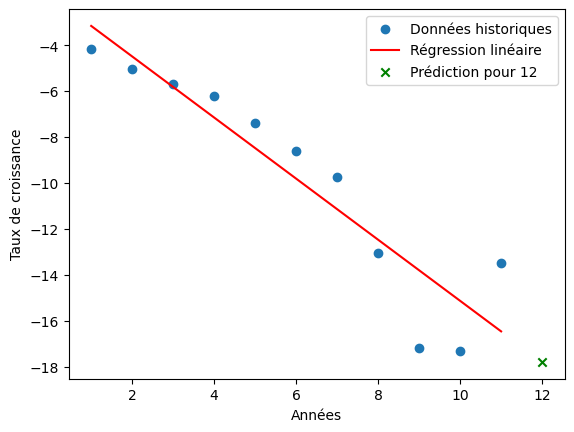

Prédiction pour Crit'Air E
Taux de croissance prédit pour l'année 12: 29.970866396706484


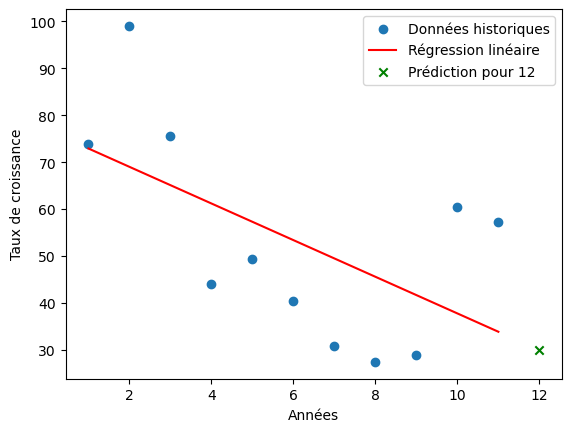

Prédiction pour Inconnu
Taux de croissance prédit pour l'année 12: -5.5216195746969206


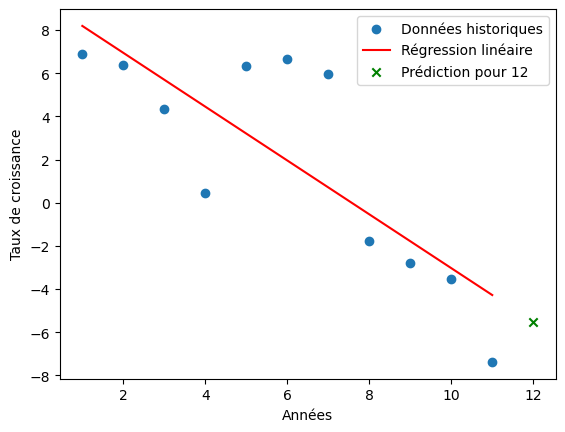

Prédiction pour Non classé
Taux de croissance prédit pour l'année 12: -19.6649675316322


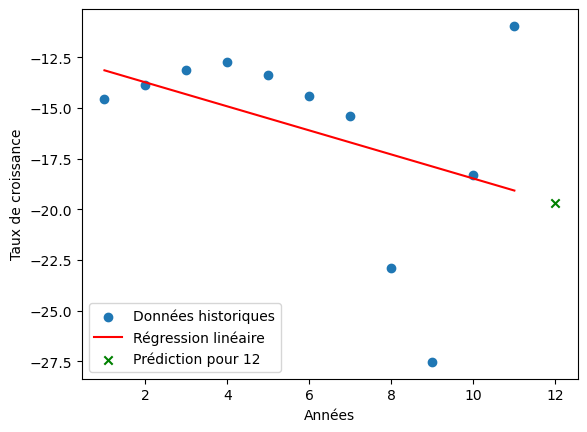

In [55]:
for i in range (0,8):
    print(f'Prédiction pour {taux_de_croissance.index[i]}') 
    prediction(i)

In [56]:
annee_future=np.arange(12,25)
taux2022=taux_de_croissance['PARC_2022'].copy()
taux2022=pd.DataFrame(taux2022)

def prediction_dataframe():
    for k in annee_future:
        n=np.zeros(8)
        for i in range (0,8):
            modele.fit(annees, taux_de_croissance.iloc[i])
            taux=modele.predict([[k]])
            n[i]=taux
        taux2022[f'PARC_20{k+11}']=n
    return taux2022

In [57]:
taux_de_croissance_predit=prediction_dataframe()
taux_de_croissance_predit


/tmp/ipykernel_245/1219056733.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=taux
/tmp/ipykernel_245/1219056733.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=taux
/tmp/ipykernel_245/1219056733.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=taux
/tmp/ipykernel_245/1219056733.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from yo

,PARC_2022,PARC_2023,PARC_2024,PARC_2025,PARC_2026,PARC_2027,PARC_2028,PARC_2029,PARC_2030,PARC_2031,PARC_2032,PARC_2033,PARC_2034,PARC_2035
CRITAIR,,,,,,,,,,,,,,
Crit'Air 1,12.563480,-2.895813,-8.916468,-14.937123,-20.957778,-26.978433,-32.999089,-39.019744,-45.040399,-51.061054,-57.081709,-63.102364,-69.123019,-75.143674
Crit'Air 2,2.453101,-5.862634,-9.456723,-13.050812,-16.644902,-20.238991,-23.833080,-27.427169,-31.021258,-34.615348,-38.209437,-41.803526,-45.397615,-48.991705
Crit'Air 3,-6.798498,-7.395148,-8.030224,-8.665300,-9.300376,-9.935452,-10.570528,-11.205604,-11.840681,-12.475757,-13.110833,-13.745909,-14.380985,-15.016061
Crit'Air 4,-10.666583,-12.471375,-13.562331,-14.653288,-15.744244,-16.835201,-17.926157,-19.017113,-20.108070,-21.199026,-22.289983,-23.380939,-24.471895,-25.562852
Crit'Air 5,-13.477294,-17.784534,-19.113775,-20.443015,-21.772255,-23.101495,-24.430735,-25.759975,-27.089215,-28.418456,-29.747696,-31.076936,-32.406176,-33.735416
Crit'Air E,57.197859,29.970866,26.067380,22.163893,18.260406,14.356919,10.453432,6.549945,2.646458,-1.257028,-5.160515,-9.064002,-12.967489,-16.870976
Inconnu,-7.372482,-5.521620,-6.767771,-8.013923,-9.260074,-10.506226,-11.752378,-12.998529,-14.244681,-15.490832,-16.736984,-17.983136,-19.229287,-20.475439
Non classé,-10.951793,-19.664968,-20.257995,-20.851023,-21.444051,-22.037079,-22.630107,-23.223134,-23.816162,-24.409190,-25.002218,-25.595246,-26.188273,-26.781301


Text(0.5, 1.0, "Estimation du taux de croissance pour les crit'air inconnu (6)")

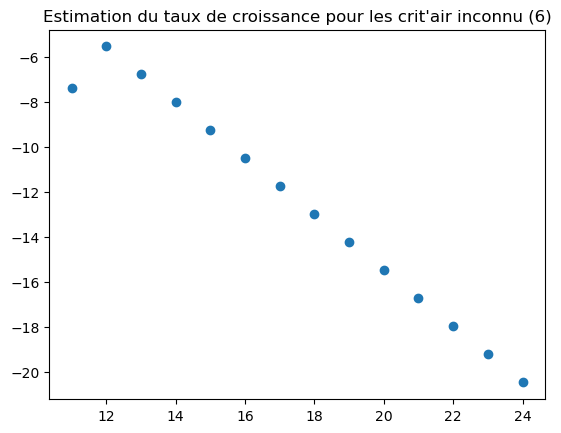

In [59]:
a=np.arange(11,25)
plt.scatter(a, taux_de_croissance_predit.iloc[6], label='Données historiques')
plt.title("Estimation du taux de croissance pour les crit'air inconnu (6)")

In [109]:
k=15
n=np.zeros(8)
for i in range (0,8):
            modele.fit(annees, taux_de_croissance.iloc[i])
            taux=modele.predict([[k]])
            print(taux)
            n[i]=taux
print(n)
taux_de_croissance[f'PARC_20{k+11}']=n

[-20.95777839]
[-16.64490158]
[-9.30037611]
[-15.7442442]
[-21.77225483]
[18.26040584]
[-9.26007436]
[-21.44405097]
[-20.95777839 -16.64490158  -9.30037611 -15.7442442  -21.77225483
  18.26040584  -9.26007436 -21.44405097]


/var/folders/0d/wtg1_x4x6vgglvz6ksylz56c0000gn/T/ipykernel_1948/3578568135.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=(taux)
/var/folders/0d/wtg1_x4x6vgglvz6ksylz56c0000gn/T/ipykernel_1948/3578568135.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=(taux)
/var/folders/0d/wtg1_x4x6vgglvz6ksylz56c0000gn/T/ipykernel_1948/3578568135.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=(taux)
/var/folders/0d/wtg1_x4x6vgglvz6ksylz56c0000gn/T/ipy

## Évolution véhicules neufs

In [3]:
#On va vouloir créer un tableau avec le nombre de véicules de 0an pour chaque années en fonction du crit'air et 
#du carburant.

#Crit'air:

data_neuf=data[data.AGE=="0 an"].copy()
data_neuf.groupby(['CARBURANT'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum()

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CARBURANT,,,,,,,,,,,
Diesel,2033701,2053089,1802413,1611497,1566498,1517942,1484798,1353412,1280127,957464,818332
Diesel HNR,3,578,8895,13344,9160,4772,1155,3023,12031,24615,38778
Electrique et hydrogène,980,4224,9141,13426,14733,27987,31416,39715,51458,121002,177081
Essence,580486,585859,488391,545813,607058,907712,1037721,1242605,1347010,826560,732770
Essence HNR,1255,1390,14289,32798,32382,46730,69202,90661,98234,152401,272876
Gaz et inconnu,76833,13131,3084,3764,3281,2063,3442,4793,5792,21086,52473
Hybride rechargeable,6510,8823,3556,872,1997,7559,11835,14502,18557,74773,141439


In [4]:
#Carburant:

data_neuf.groupby(['CRITAIR'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum()

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CRITAIR,,,,,,,,,,,
Crit'Air 1,350509,598331,508676,582973,644543,963820,1121952,1352493,1469505,1074770,1199534
Crit'Air 2,942975,1756084,1729819,1571899,1562544,1521144,1485712,1356371,1292094,982050,857088
Crit'Air 3,1395099,302480,79713,52163,12858,1587,235,77,59,25,27
Crit'Air 4,1385,1489,146,58,15,14,15,4,12,3,2
Crit'Air 5,10,5,3,2,2,5,0,0,4,3,1
Crit'Air E,984,4099,8819,13311,14703,27987,31416,39716,51458,121002,177081
Inconnu,769,146,163,170,141,200,237,50,76,47,16
Non classé,8037,4460,2430,938,303,8,2,0,1,1,0


/opt/mamba/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


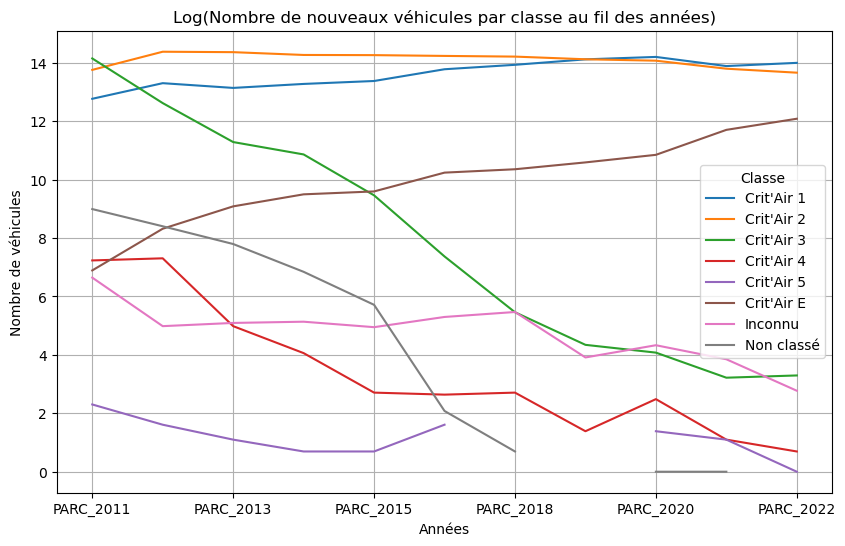

In [13]:
df1=data_neuf.groupby(['CRITAIR'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum().reset_index()
df1.iloc[:,1:]=np.log(df1.iloc[:,1:])
df1

# Sélectionnez les colonnes avec les années
annees = df1.columns[1:]  # Supposant que les années commencent à la deuxième colonne

# Groupez les données par classe et trouvez la somme des véhicules pour chaque année
donnees_agroupees = df1.groupby('CRITAIR')[annees].sum()

# Transposez les données pour les avoir sous une forme plus adéquate pour le tracé
donnees_transposees = donnees_agroupees.T

# Tracer un graphique pour chaque classe de véhicules
donnees_transposees.plot(kind='line', figsize=(10, 6))
plt.title('Log(Nombre de nouveaux véhicules par classe au fil des années)')
plt.xlabel('Années')
plt.ylabel('Nombre de véhicules')
plt.legend(title='Classe')
plt.grid(True)
plt.show()

In [5]:
#Il serait intéressant de pouvoir voir le nombre de nouvelles voitures qui rentrent sur le marché chaque année en
#fonction du modèle

data_neuf.groupby(['CATEGORIE_VEHICULE'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum()

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CATEGORIE_VEHICULE,,,,,,,,,,,
Autobus,1605,1742,1688,1963,1550,1553,1569,1661,1819,1829,2204
Autocar,4332,5160,4494,5021,4575,5225,4871,4754,5119,4455,4973
Autre VASP,8135,7214,8233,6805,7649,9917,10675,11025,13072,13905,14719
Camion,13370,17683,17032,15584,14159,17407,19654,20921,21680,17829,18406
Camionnette,294651,300732,269781,259977,264255,300050,329411,349886,369938,312060,337211
Camping-car,16741,17489,15867,15193,14440,18865,20591,22949,23159,24468,30536
Dérivé VP,79541,84494,75506,70790,74225,88534,91817,89840,85788,62106,66332
Tracteur routier,18085,26638,23709,24853,20837,27005,27748,30082,30907,21003,22875
VASP lourd,4916,5421,5203,4952,4341,4389,4606,5238,5560,4906,5084


In [6]:
#Nous voyons que le nombre de nouveaux véhicules particuliers a tendance à baisser au fil des années.

In [10]:
df2=data_neuf.groupby(['CATEGORIE_VEHICULE'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum().reset_index()
df2.iloc[:,1:]=np.log(df2.iloc[:,1:])
df2

,CATEGORIE_VEHICULE,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Autobus,7.380879,7.462789,7.431300,7.582229,7.346010,7.347944,7.358194,7.415175,7.506042,7.511525,7.698029
1,Autocar,8.373785,8.548692,8.410498,8.521384,8.428362,8.561210,8.491055,8.466742,8.540714,8.401782,8.511779
2,Autre VASP,9.003931,8.883779,9.015906,8.825413,8.942330,9.202006,9.275660,9.307921,9.478228,9.540004,9.596894
3,Camion,9.500769,9.780359,9.742849,9.654000,9.558106,9.764628,9.886036,9.948509,9.984145,9.788582,9.820432
4,Camionnette,12.593547,12.613975,12.505366,12.468348,12.484670,12.611704,12.705061,12.765363,12.821091,12.650951,12.728464
5,Camping-car,9.725616,9.769327,9.671997,9.628590,9.577757,9.845064,9.932609,10.041030,10.050139,10.105121,10.326662
6,Dérivé VP,11.284028,11.344436,11.231967,11.167473,11.214856,11.391142,11.427553,11.405786,11.359634,11.036598,11.102428
7,Tracteur routier,9.802838,10.190094,10.073610,10.120734,9.944486,10.203777,10.230919,10.311682,10.338738,9.952421,10.037800
8,VASP lourd,8.500250,8.598036,8.556991,8.507547,8.375860,8.386857,8.435115,8.563695,8.623353,8.498214,8.533854
9,Véhicule particulier,14.630164,14.604205,14.461700,14.412354,14.419323,14.529352,14.570988,14.609568,14.629178,14.355122,14.364446


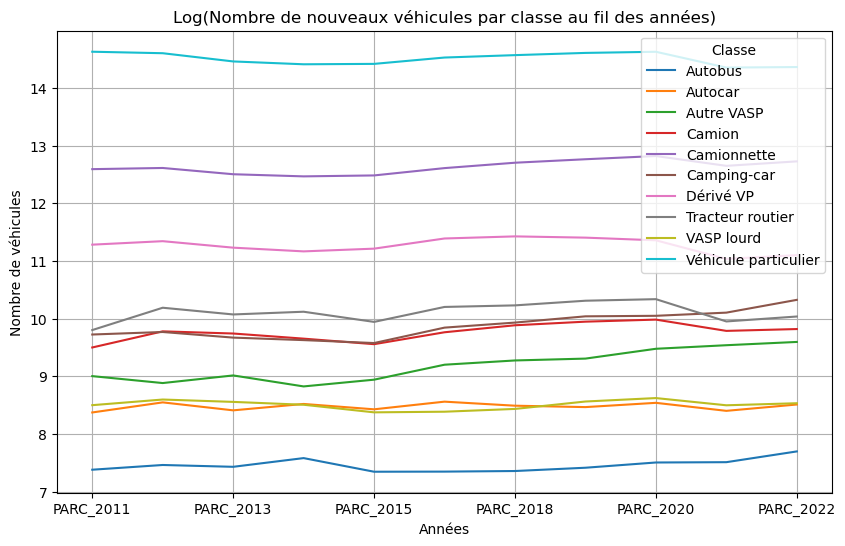

In [11]:
# Supposons que 'Classe' est le nom de la colonne représentant la classe de véhicules
# et que les colonnes suivantes représentent les années de 2011 à 2022

# Sélectionnez les colonnes avec les années
annees = df2.columns[1:]  # Supposant que les années commencent à la deuxième colonne

# Groupez les données par classe et trouvez la somme des véhicules pour chaque année
donnees_agroupees = df2.groupby('CATEGORIE_VEHICULE')[annees].sum()

# Transposez les données pour les avoir sous une forme plus adéquate pour le tracé
donnees_transposees = donnees_agroupees.T

# Tracer un graphique pour chaque classe de véhicules
donnees_transposees.plot(kind='line', figsize=(10, 6))
plt.title('Log(Nombre de nouveaux véhicules par classe au fil des années)')
plt.xlabel('Années')
plt.ylabel('Nombre de véhicules')
plt.legend(title='Classe')
plt.grid(True)
plt.show()

In [9]:
#A l'aide de ce nouveau graphique, nous semblons voir que l'entrée de nouveau véhicules semble régulier depuis 2011

## Estimation du modèle probabilistique

In [ ]:
# Définir les paramètres de la distribution binomiale
n = 10  # Nombre d'essais
p = 0.5  # Probabilité de succès

# Générer des variables aléatoires binomiales
donnees_aleatoires = binom.rvs(n=n, p=p, size=1000)

# Calculer la probabilité d'obtenir k succès
k = 5
probabilite_k_succes = binom.pmf(k, n, p)

# Calculer la fonction de répartition (CDF) jusqu'à k
cdf_k = binom.cdf(k, n, p)

# Afficher les résultats
print("Données aléatoires binomiales :", donnees_aleatoires)
print(f"Probabilité d'obtenir {k} succès :", probabilite_k_succes)
print(f"CDF jusqu'à {k} succès :", cdf_k)

## Représentation graphique

In [ ]:
france = download_vectorfile_url_all(
      values = "metropole",
      crs = 4326,
      borders = "REGION",
      vectorfile_format="topojson",
      filter_by="FRANCE_ENTIERE",
      source="EXPRESS-COG-CARTO-TERRITOIRE",
      year=2022)

In [ ]:
france.head()

In [ ]:
#base=france.boundary.plot(edgecolor="black", linewidth=0.5)

In [ ]:
#merged = france.set_index('NOM').join(data.set_index('REGION_LIBELLE'))

# Créer une carte
#fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#merged.plot(column='CARBURANT', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Ajouter une légende
#ax.legend(title='Carburant', loc='upper left', bbox_to_anchor=(1, 1))